In [1]:
import numpy as np
import torch
import re
import jieba
import newspaper
import pandas as pd
from tqdm import tqdm
import os.path
from os import listdir
import torch
from IPython.display import display, Image
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

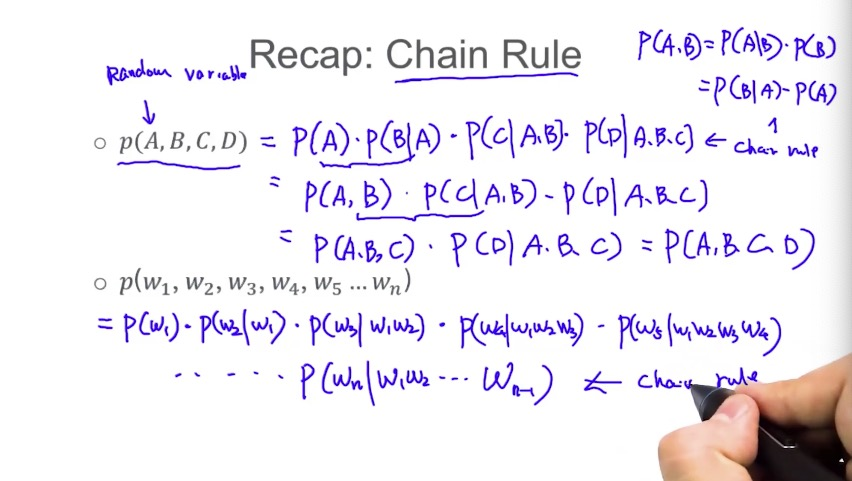

In [2]:
display( Image( filename = "/Users/manmanzhang/Library/Mobile Documents/com~apple~CloudDocs/MyProject/InferenceSystem/src/I5_algorithm/NLP训练营笔记/图片/BEEAE46F-1CA2-41EC-AB1C-A4E66BDE502F.png" ))

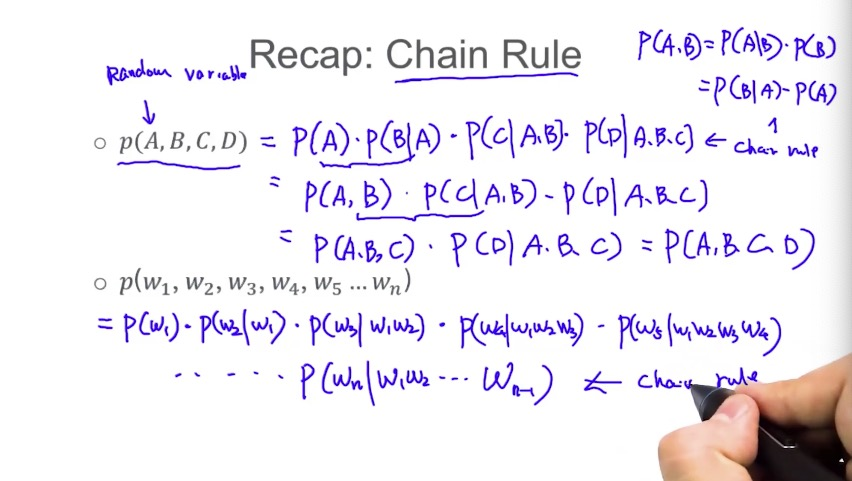

In [3]:
display( Image( filename = "/Users/manmanzhang/Library/Mobile Documents/com~apple~CloudDocs/MyProject/InferenceSystem/src/I5_algorithm/NLP训练营笔记/图片/BEEAE46F-1CA2-41EC-AB1C-A4E66BDE502F.png" ))

In [4]:
def find_file(key_word,dir = os.getcwd()):
    file_paths = [os.path.join(dir, f) for f in listdir(dir) if os.path.isfile(os.path.join(dir, f)) and key_word in os.path.join(dir, f)][0]
    return file_paths

In [5]:
# 加载文本
corpus = find_file("南方网 3.csv")
stop_word_path = find_file("stop_word_for_chinese.txt","/Users/manmanzhang/Library/Mobile Documents/com~apple~CloudDocs/MyProject/InferenceSystem/src/I5_algorithm/NLP数据集合/停词库/")
stop_word_path

'/Users/manmanzhang/Library/Mobile Documents/com~apple~CloudDocs/MyProject/InferenceSystem/src/I5_algorithm/NLP数据集合/停词库/stop_word_for_chinese.txt'

In [6]:
#临时删除文本元素
def del_element(strings,symbles):
    srcrep = {i:'' for i in symbles }
    rep = dict((re.escape(k), v) for k, v in srcrep.items())
    pattern = re.compile("|".join(rep.keys()))
    return pattern.sub(lambda m: rep[re.escape(m.group(0))], strings)

#加载停用词
stop_words = stop_words = open(stop_word_path,'r').read().split('\n')+['\n']

#过滤停用词
def filter_stop_word(paper,stop_words):
    return np.array(list(filter(lambda x: x not in stop_words,jieba.cut(del_element(paper,'\n')))))

#读取本地新闻
def read_txt(corpus):
    return np.array([re.sub('\n','',str(word)) for word in tqdm(pd.read_csv(corpus).text,desc='加载文章')])

#只要中文
def just_chinese(strings):
    regStr = ".*?([\u4E00-\u9FA5]+).*?"
    expr = ''.join(re.findall(regStr, strings))
    if expr:
        return expr
    return '\n'

#分词
def split_word(original,temp_del=stop_words):
    result = []
    for paper in tqdm(original,desc='分词文章'):
        chinese = just_chinese(paper)
        temp_split_words = filter_stop_word(chinese,stop_words)
        result.append(temp_split_words)
    return np.array(result)

# 排序字典
def sort_dict(dict_items):
    sorted_tuple = np.array(sorted(dict_items.items(), key=lambda x: x[0], reverse=True))
    return dict(zip(sorted_tuple[:,0],sorted_tuple[:,1]))


# 字典编码+Torch结构化

In [283]:
# 单词编码器
def word_encoding(all_word):
    return {all_words[i]:i for i in tqdm(range(all_words.size),desc='单词编码字典')}

# 编码向量
def encode_papers(split_paper,encode_dict):
    # 所有单词降维到一维
    all_words = np.array([j for i in tqdm(split_paper,desc='词列表降维') for j in i])
    return [torch.tensor([encode_dict[word] for word in paper]) for paper in split_paper]

'''数据预处理函数'''
def data_preprocessing_to_tensor(corpus):
    # 读取原文
    read_original = read_txt(corpus) 
    # 倒入文章并分词
    split_paper = split_word(read_original,stop_words)
    # 所有单词降维到一维
    all_words = np.array([j for i in tqdm(split_paper,desc='词列表降维') for j in i])
    # 单词编码字典
    encode_dict = word_coding(all_words)
    # 单词解码字典
    decode_dict = dict(zip(encode_dict.values(), encode_dict.keys()))
    # 转tensor
    code_paper = encode_papers(split_paper,encode_dict)
    # 编码向量
    code_tensor = torch.unique(torch.tensor(list(decode_dict)))
    return decode_dict,encode_dict,code_paper,code_tensor,all_words,read_original,split_paper

#静态配置
decode_dict,encode_dict,code_paper,code_tensor,all_words,read_original,split_paper = data_preprocessing_to_tensor(corpus)

'''TF-IDF torch'''
def TF_Tensor(tensor_paper,code_tensor):
    unique,counts = torch.unique(tensor_paper,return_counts=True)
    init_TF = torch.zeros(code_tensor.size())
    for e,c in zip(unique,counts):
        if e in code_tensor:
            index_ = np.where(code_tensor == e)[0][0]
            init_TF[index_] = c
    return init_TF

def IDF_Tensor(tensor_papers,code_tensor):
    N = len(tensor_papers)
    NW = torch.zeros(code_tensor.size())
    step = -1
    for word_code in tqdm(code_tensor,desc="IDF词汇"):
        step += 1
        counter = sum((word_code in paper_code for paper_code in tensor_papers))
        NW[step] = counter
    return torch.log(N/(NW+1))

def TFIDFTensor(tensor_papers,code_tensor):
    IDF = IDF_Tensor(tensor_papers,code_tensor)
    m = len(tensor_papers)
    n = int(code_tensor.size()[0])
    DF = torch.zeros(m,n)
    step = -1
    for paper in tqdm(tensor_papers,desc="TF矩阵"):
        step += 1
        DF[step] = TF_Tensor(paper,code_tensor)
    return DF*IDF

词列表降维: 100%|██████████| 1217/1217 [00:00<00:00, 7159.08it/s]


In [284]:
TFIDF = TFIDFTensor(code_paper,code_tensor)

TF矩阵: 100%|██████████| 1217/1217 [00:41<00:00, 29.25it/s]


# one hot 编码

In [ ]:
read_original = read_txt(corpus)[:10]  
# 倒入文章并分词
split_paper = split_word(read_original,stop_words)
# 所有单词降维到一维
all_words = np.array([j for i in tqdm(split_paper,desc='词列表降维') for j in i])

# 单篇文章转 torch.IntTensor one-hot
def one_hot_row(paper,all_words):
    init_one_hot = np.zeros(all_words.size)
    n = -1
    for word in paper:
        n += 1
        if word in all_words:
            init_one_hot[n]=1
    return init_one_hot

# 所有文章转 torch.IntTensor one-hot
def one_hot(paper,all_words):
    return np.array([one_hot_row(paper_words,all_words) for paper_words in tqdm(split_paper,desc='所有文章编码化')])

# 独热编码
#paper_of_one_hot = one_hot(split_paper,all_words)

# numpy 预处理

In [ ]:
'''数据预处理函数'''
def data_preprocessing_numpy(corpus):
    # 读取原文
    read_original = read_txt(corpus) 
    # 倒入文章并分词
    init_paper = split_word(read_original,stop_words)
    # 所有单词降维到一维
    all_words = np.array([j for i in tqdm(init_paper,desc='词列表降维') for j in i])
    # 单词去重
    word_vector = np.unique(all_words)
    # 测量共有词汇量
    m = all_words.size
    init_word_dict = {word:(all_words==word).dot(np.ones(m))/m for word in tqdm(word_vector,desc='构建频率词典')}
    #构建排序字典和特征向量 
    word_dict = sort_dict(init_word_dict)
    word_vector = np.array(list(word_dict)) 
    return word_dict,word_vector,read_original,init_paper

